In [1]:
import scipy.io
import numpy as np 
import pdb
import torch
from common.data_normalization import *
from common.pt_build_model import *
import matplotlib.pyplot as plt
import glob,pickle,os,copy,sys,random
from sys import argv
from process_params import *
# argv lr heldout nntype seed dropout nodes epoch p4p true_load nm ne suffix(avi_,v1_,...)

[175, 48, 49, 176, 177]
Rolling out 7test trajectories.


/usr/local/lib/python3.6/site-packages/torch/serialization.py:593: SourceChangeWarning: source code of class 'common.TrajNet.TrajNet' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


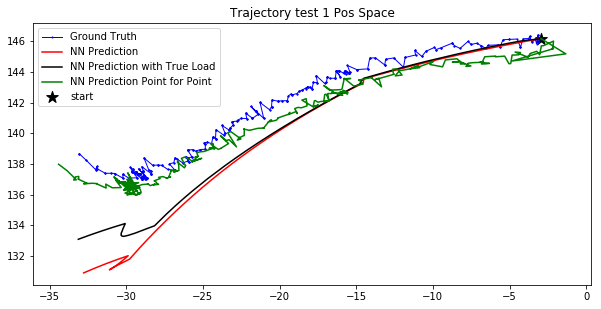

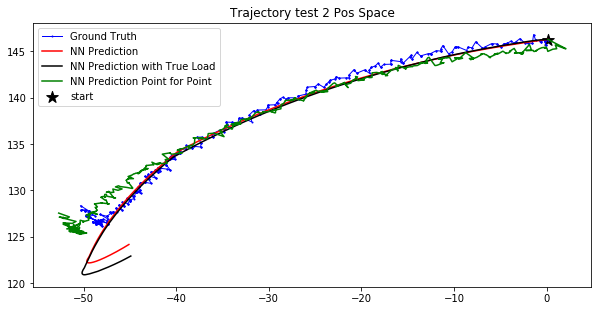

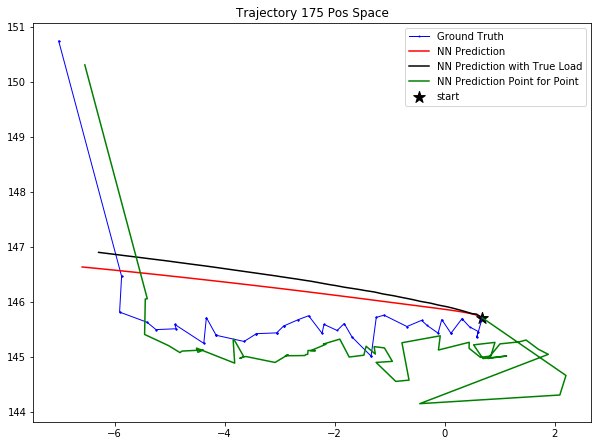

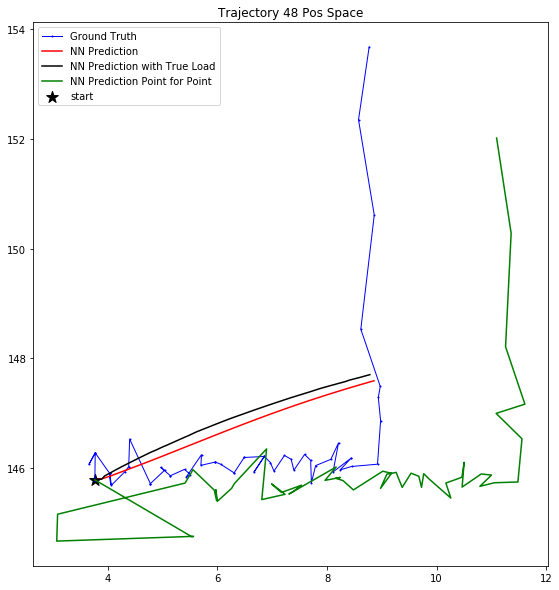

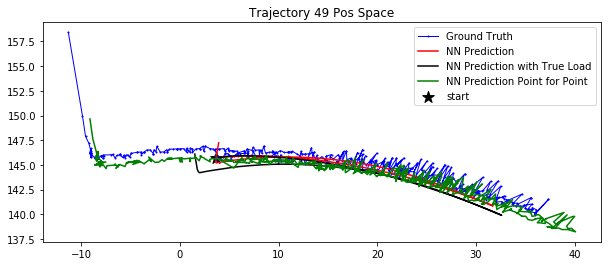

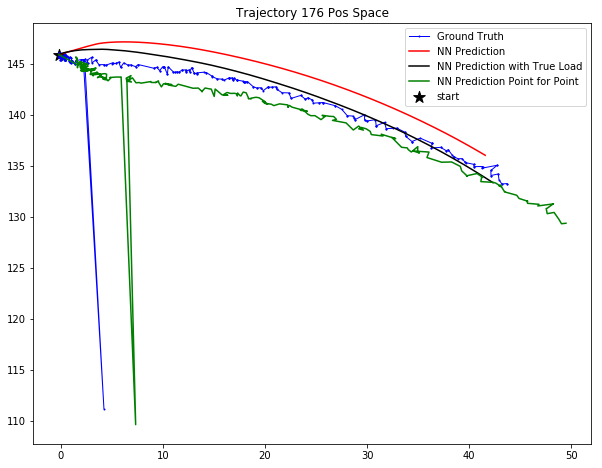

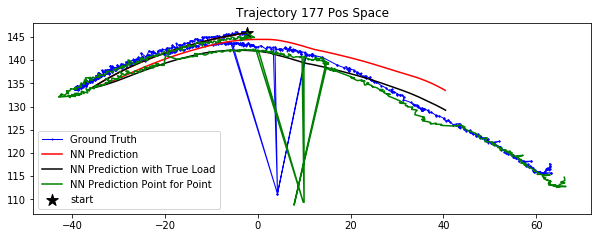

In [2]:
nodes=200
seed=0
nn_type = '2'
held_out = .0
lr = .0001
dropout_rate = .0
p4p=1
true_load=1
ep=50
p4p=1
true_load=1
suffix=''
if len(argv)>3:
    lr=float(argv[1])
    held_out=float(argv[2])
    nn_type=argv[3]
    seed=int(argv[4])
    dropout_rate=float(argv[5])
    nodes=int(argv[6])
    ep=int(argv[7])
    p4p=int(argv[8])
    true_load=int(argv[9])
    if len(argv)>10:
        dm=argv[10]
        train_mode=argv[11]
        suffix=argv[12]
data_mode=data_mode[:-2]+dm

if train_separate:
    if 'avi_' not in suffix: 
        #test_ds_path=base_path+color+'_data/'+obj+'/test/test_separate_'+data_type+'_v'+test_idx+data_mode
        #train_ds_path=base_path+color+'_data/'+obj+'/train_separate_'+data_type+'_v'+test_idx+data_mode
        test_ds_path=base_path+color+'_data/'+obj+'/test/test_separate_'+data_type+'_v'+test_idx+data_mode+'_'+suffix+'f'
        train_ds_path=base_path+color+'_data/'+obj+'/train_separate_'+data_type+'_v'+test_idx+data_mode+'_'+suffix+'f'
    else:
        #test_ds_path=base_path+color+'_data/'+obj+'/test/avi_test_separate_'+data_type+data_mode
        #train_ds_path=base_path+color+'_data/'+obj+'/avi_train_separate_'+data_type+data_mode
        test_ds_path=base_path+color+'_data/'+obj+'/test/avi_test_separate_'+data_type+data_mode+'_'+suffix+'f'
        train_ds_path=base_path+color+'_data/'+obj+'/avi_train_separate_'+data_type+data_mode +'_'+suffix+'f'
#Assume episodes are always separated
else:
    raise    
if train_separate:
    test_ds_path=base_path+color+'_data/'+obj+'/test/test_separate_'+data_type+'_v'+test_idx+data_mode+'_'+suffix+'f'
    train_ds_path=base_path+color+'_data/'+obj+'/train_separate_'+data_type+'_v'+test_idx+data_mode+'_'+suffix+'f'

with open(test_ds_path, 'rb') as pickle_file:
     test_ds_ls,test_ds_all_ls,state_dim,action_dim,test_traj_gt_ls,real_test_actions_ls = pickle.load(pickle_file)
with open(train_ds_path, 'rb') as pickle_file:
     train_ds_ls,train_ds_all_ls,state_dim,action_dim,train_traj_gt_ls,real_train_actions_ls = pickle.load(pickle_file)

train_test_idx=[np.random.randint(len(train_ds_ls))]
train_test_idx=[175,48,49,176,177]
print(train_test_idx)
if len(train_test_idx)!=1:
    test_ds_ls+=[train_ds_ls[tt_idx] for tt_idx in train_test_idx]
    test_ds_all_ls+=[train_ds_all_ls[tt_idx] for tt_idx in train_test_idx]
    test_traj_gt_ls+=[train_traj_gt_ls[tt_idx] for tt_idx in train_test_idx]
    real_test_actions_ls+=[real_train_actions_ls[tt_idx] for tt_idx in train_test_idx]
else:
    test_ds_ls.append(train_ds_ls[train_test_idx[0]])
    test_ds_all_ls.append(train_ds_all_ls[train_test_idx[0]])
    test_traj_gt_ls.append(train_traj_gt_ls[train_test_idx[0]])
    real_test_actions_ls.append(real_train_actions_ls[train_test_idx[0]])
train_test_idx=['test 1','test 2']+train_test_idx

task_ofs = state_dim + action_dim
test_ds = [torch.tensor(data, dtype=dtype) for data in test_ds_ls]
test_ds_all = [torch.tensor(data, dtype=dtype) for data in test_ds_all_ls]
real_test_actions=[torch.tensor(ac, dtype=dtype) for ac in real_test_actions_ls]
test_eps_len=[ep.shape[0] for ep in test_ds_ls]
print("Rolling out " + str(len(test_ds_ls)) + "test trajectories.")

cuda = False
dtype = torch.float
#save_path = 'save_model/'
#pred_path = 'pred_fig/'
save_path = dm+'_'+train_mode+'_'+suffix+'save_model_f/'
pred_path = dm+'_'+train_mode+'_'+suffix+'pred_fig_f/'
if not os.path.exists(pred_path):
    os.makedirs(pred_path)
model_save_path = save_path + 'model_lr' + str(lr)+ '_' +'val' + str(held_out)+ '_' + 'seed' + str(seed) + '_nn_' + nn_type + '_dp_' + str(dropout_rate)+'_nodes_'+str(nodes) 
model_save_path += '_epochs_'+str(ep)
pred_fig_path = pred_path + 'traj_lr' + str(lr)+ '_' +'val' + str(held_out)+ '_' + 'seed' + str(seed) + '_nn_' + nn_type + '_dp_' + str(dropout_rate)+'_nodes_'+str(nodes)

with open(model_save_path, 'rb') as pickle_file:
    model = torch.load(pickle_file, map_location='cpu')
if cuda: 
    model = model.to('cuda')
    model.norm = tuple(n.cuda() for n in model.norm)

torch.manual_seed(seed)
model.eval()
for i in range(len(test_ds_ls)):
    tt_idx=str(train_test_idx[i])
    gt_states = test_ds_all[i][:,:state_dim]
    real_actions = real_test_actions[i]
    valid_states_for_plot = np.vstack(test_traj_gt_ls[i])
    valid_states_for_plot = torch.tensor(valid_states_for_plot, dtype=dtype)
    if cuda:
        gt_states = gt_states.cuda()
        valid_states_for_plot = valid_states_for_plot.cuda()
        model = model.to('cuda')
        model.norm = tuple([n.cuda() for n in model.norm])
    with torch.no_grad():
        pred_states = model.run_traj(gt_states,real_actions)
        if true_load:
            real_actions_loads=torch.cat((gt_states[:,2:4],test_ds_all[i][:,state_dim:state_dim+action_dim]),1)
            if cuda: real_actions_loads=real_actions_loads.cuda()
            pred_tl_states=model.run_traj_true_load(gt_states,real_actions_loads)
    if p4p:
        with torch.no_grad():
            x_mean_arr, x_std_arr, y_mean_arr, y_std_arr = model.norm
            if cuda: 
                inpt=test_ds[i].cuda()[:,:state_dim+action_dim]
                x_mean_arr=x_mean_arr.cuda()
                x_std_arr=x_std_arr.cuda()
                y_mean_arr=y_mean_arr.cuda()
                y_std_arr=y_std_arr.cuda()
            else: inpt=test_ds[i][:,:state_dim+action_dim]
            inpt_n = z_score_normalize(inpt, x_mean_arr, x_std_arr)
            state_delta = model.forward(inpt_n)
            state_delta = z_score_denormalize(state_delta, y_mean_arr, y_std_arr)
            pred_p4p_states= state_delta + inpt[:,:state_dim]
            pred_p4p_states=torch.cat((valid_states_for_plot[0,:state_dim].view(1,-1),pred_p4p_states),0)
        
        fig = plt.figure()
        plt.scatter(valid_states_for_plot[0, 0], valid_states_for_plot[0, 1], s=150, c='k', marker="*",label='start')
        plt.plot(valid_states_for_plot[:, 0], valid_states_for_plot[:, 1], color='blue', label='Ground Truth', marker='.', markersize=2, linewidth=1)
        plt.plot(pred_states[:, 0], pred_states[:, 1], color='red', label='NN Prediction')
        if true_load:
            plt.plot(pred_tl_states[:, 0], pred_tl_states[:, 1], color='k', label='NN Prediction with True Load')
        plt.plot(pred_p4p_states[:, 0], pred_p4p_states[:, 1], color='green', label='NN Prediction Point for Point')
        
        plt.axis('scaled')
        plt.title('Trajectory '+tt_idx+ ' Pos Space')
        plt.legend()
        fig_loc=pred_fig_path +'_traj_'+tt_idx+'_pos_p4p.png'
        if true_load:
            fig_loc=pred_fig_path +'_traj_'+tt_idx+'_pos_p4p_tl.png'
        if len(argv)>7:
            fig_loc=pred_fig_path +'_traj_'+tt_idx+'_epoch_'+str(ep)+'_pos_p4p.png'
            if true_load:
                fig_loc=pred_fig_path +'_traj_'+tt_idx+'_epoch_'+str(ep)+'_pos_p4p_tl.png'
        fig.set_size_inches(10, 10)
        fig.savefig(fig_loc)
    else:
        fig = plt.figure()
        plt.scatter(valid_states_for_plot[0, 0], valid_states_for_plot[0, 1], s=150, c='k', marker="*",label='start')
        plt.plot(valid_states_for_plot[:, 0], valid_states_for_plot[:, 1], color='blue', label='Ground Truth', marker='.', markersize=2, linewidth=1)
        plt.plot(pred_states[:, 0], pred_states[:, 1], color='red', label='NN Prediction')
        if true_load:
            plt.plot(pred_tl_states[:, 0], pred_tl_states[:, 1], color='k', label='NN Prediction with True Load')
        plt.axis('scaled')
        plt.title('Trajectory '+tt_idx+ ' Pos Space')
        plt.legend()
        fig_loc=pred_fig_path +'_traj_'+tt_idx+'_pos.png'
        if true_load:
            fig_loc=pred_fig_path +'_traj_'+tt_idx+'_pos_tl.png'
        if len(argv)>7:
            fig_loc=pred_fig_path +'_traj_'+tt_idx+'_epoch_'+str(ep)+'_pos.png'
            if true_load:
                fig_loc=pred_fig_path +'_traj_'+tt_idx+'_epoch_'+str(ep)+'_pos_tl.png'
        fig.set_size_inches(10, 10)
        fig.savefig(fig_loc)